Dataset from [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

Inspiration from [here](https://www.kaggle.com/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed)

Using the different medical predictor (BMI, insulin level, age etc) to predict if a patient has diabetes or not

**Steps**

O - Obtain Data <br>
C - Clean Data <br>
E - Explore Data <br>
A - Analyse Data/ML <br>
N - Interpret Data <br>


In [10]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno


# Obtain Data

In [11]:
# Obtain Data
data = pd.read_csv("diabetes.csv")
print (data.shape, data.columns)
data.head(5)

## Outcome indicates that the person has diabetes.
## The outcome is normalized?

(768, 9) Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


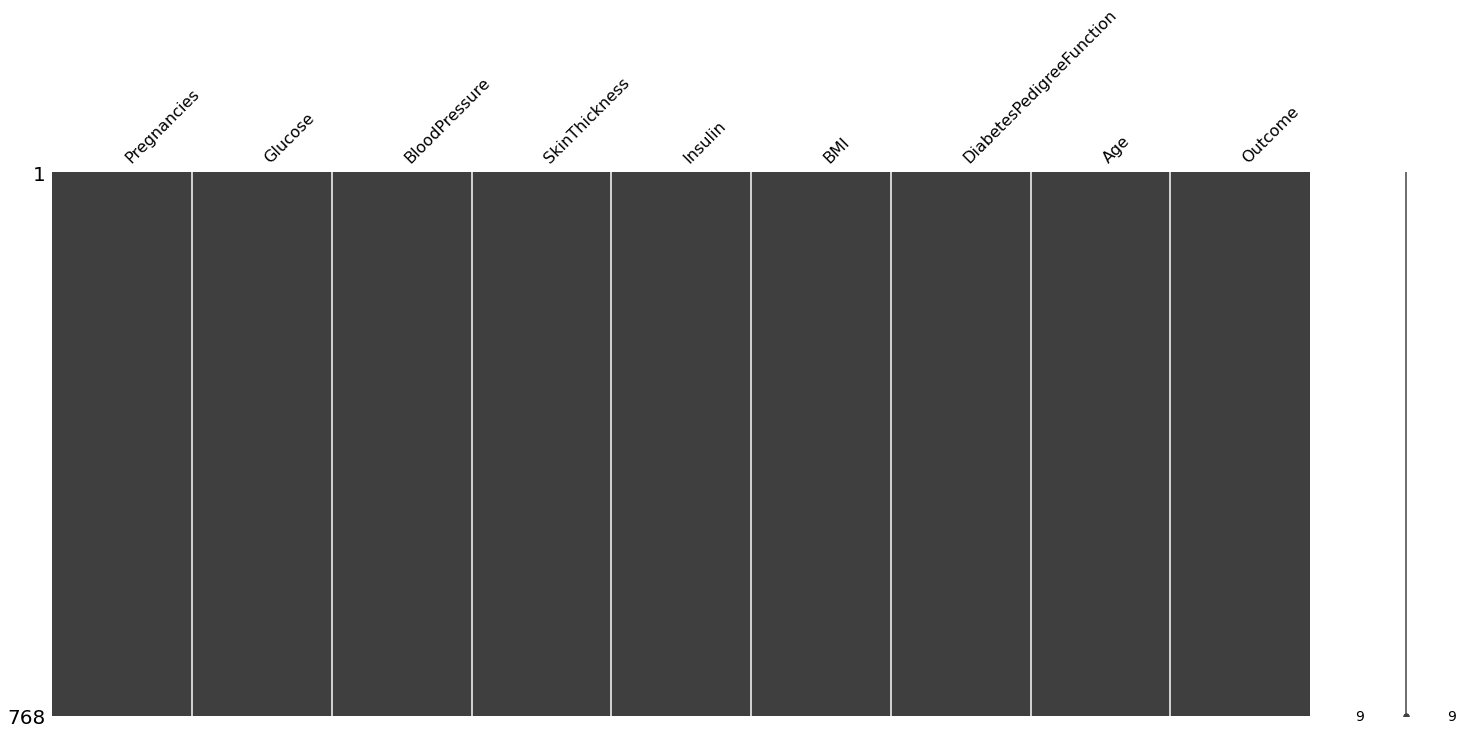

In [13]:
msno.matrix(data)
# No null values

for i in data.columns:
    null_percent = data[i].isna().sum() / len(data)
    null_percent = null_percent * 100
    if null_percent > 0:
        print (f"{i} : {null_percent} %")


# Clean Data

As shown in the summary table with the function describe(), you can see that for some predictor variables there is a min value of zero. However this is not logically possible, to have zero glucose, bmi, skin thickness etc hence we can assume that these **are likely** to be invalid entries

To facilitate the cleaning process, it will be better to replace them with NA values and to drop them afterwards. 

> data.replace(0, np.nan, inplace=True)

In [14]:
data1 = data.copy(deep = True)
data1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


We only want to replace the predictor variables column and **NOT** the outcome column. So we have to index the right columns


In [15]:
data1[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data1[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

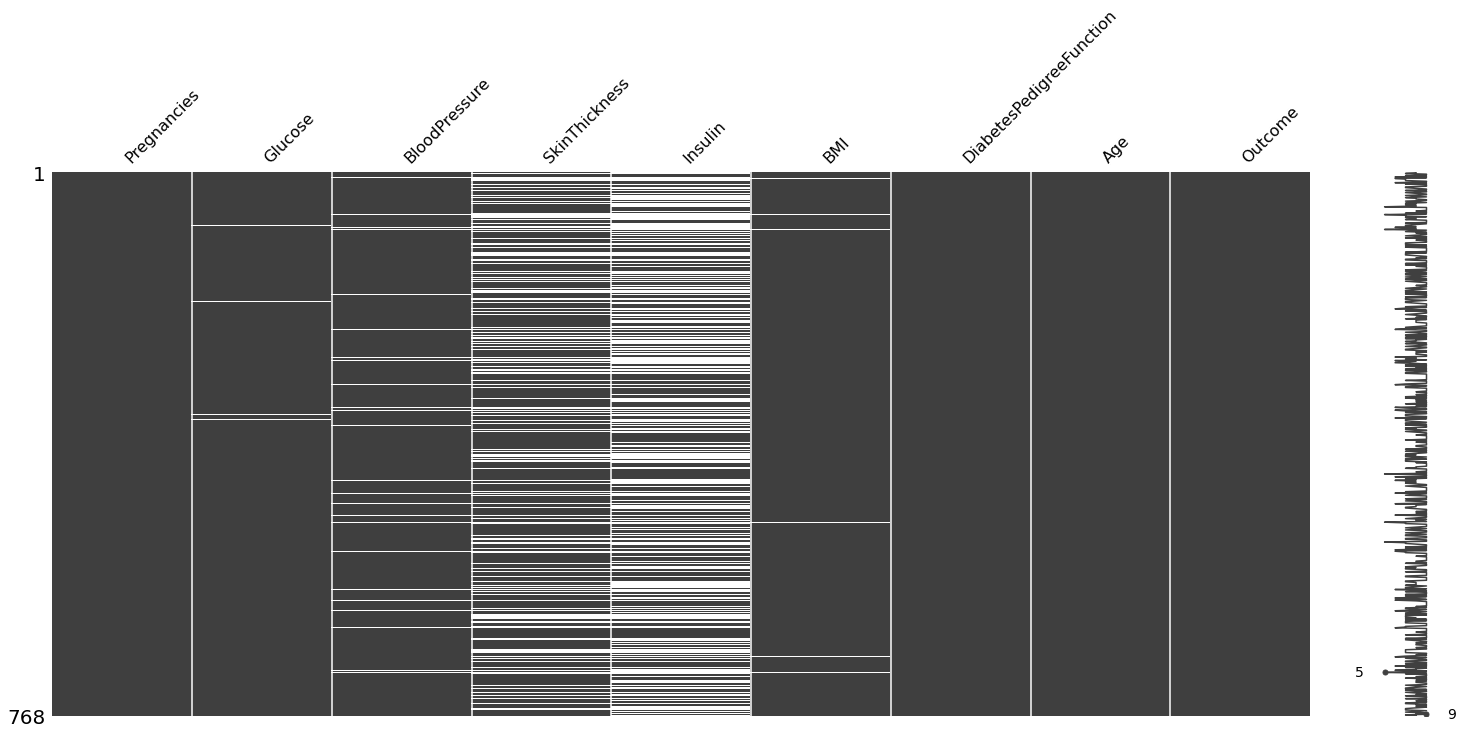

In [16]:
msno.matrix(data1)

In [17]:
# Show the number of NaN values in each of the column
data1.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

We have an option to either drop these Nan values or to fill them up with the mean

(1) If we drop the NaN values, our sample size will be smaller. The model might not be a good prediction for people of different predictor variables
(2) If we fill them up with the mean, it is slightly better. Sample size remains and it will provide a better fit???

We first plot a **histogram**

The purpose is to determine if the current data is **left skewed, medium or right skewed**

Which allows us to determine if we should replace the NaN values with **mean** or **median**

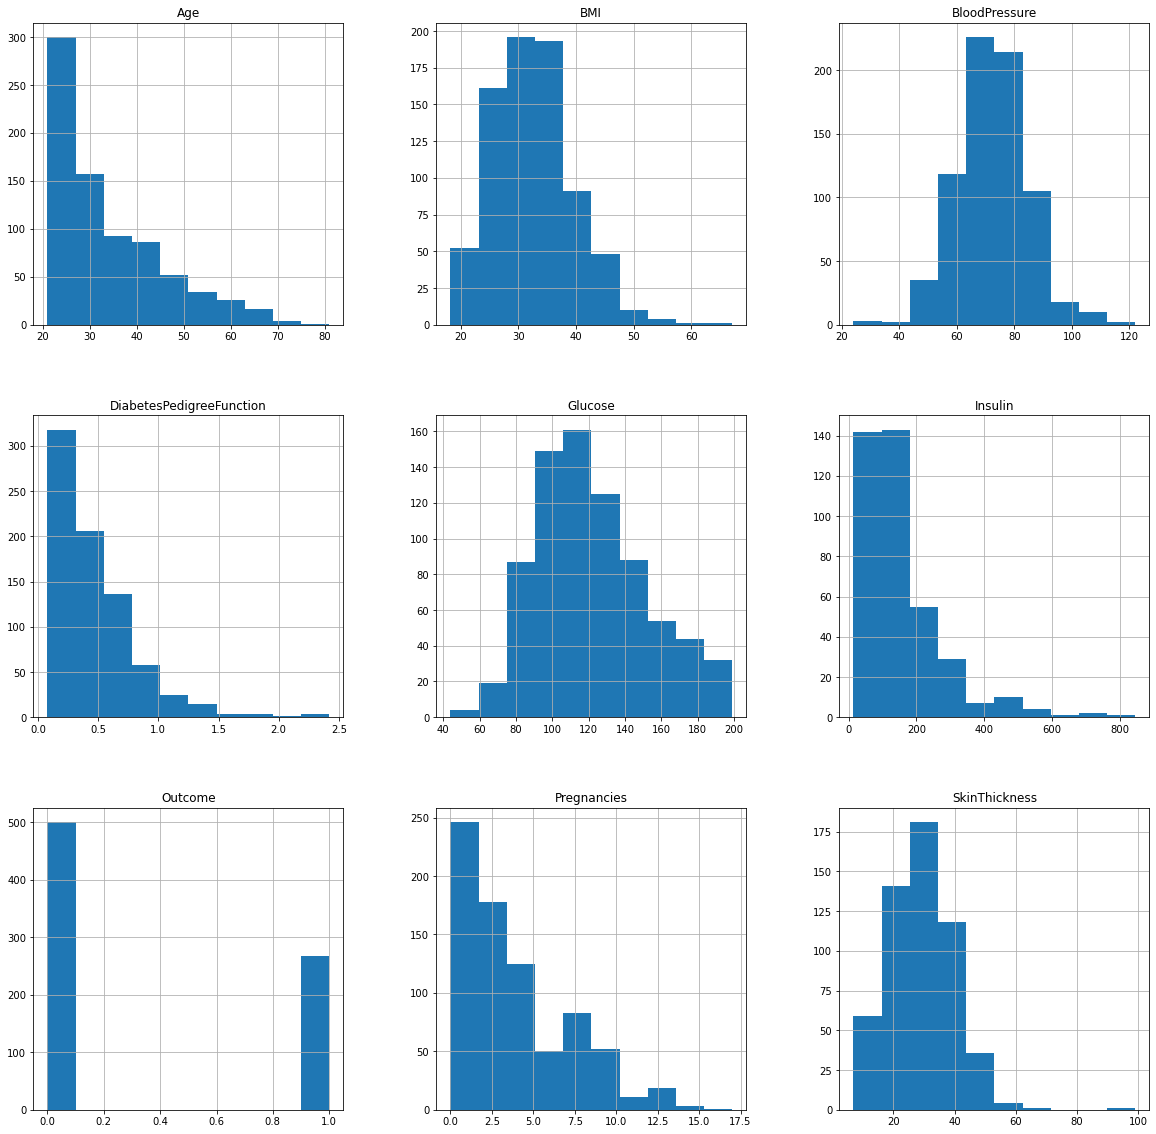

In [18]:
# Plot a histogram

data1_hist = data1.hist(figsize = (20,20))

Based on the above Histogram,


**BMI, SkinThickness, Insulin**  seems to be a bit left skewed, so we should use median

**Blood pressure, Glucose** is medium, so we can use mean



In [19]:
median_list = ["BMI", "SkinThickness", "Insulin"]
mean_list = ["BloodPressure", "Glucose"]

for i in median_list:
    data1[i].fillna(data[i].mean(), inplace = True)
    
for x in mean_list:
    data1[x].fillna(data[x].mean(), inplace = True)
    


In [20]:
# Check if there is still NaN values
data1.isnull().sum()

## Yay go no Null value


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Explore Data

**Replot the Histogram**

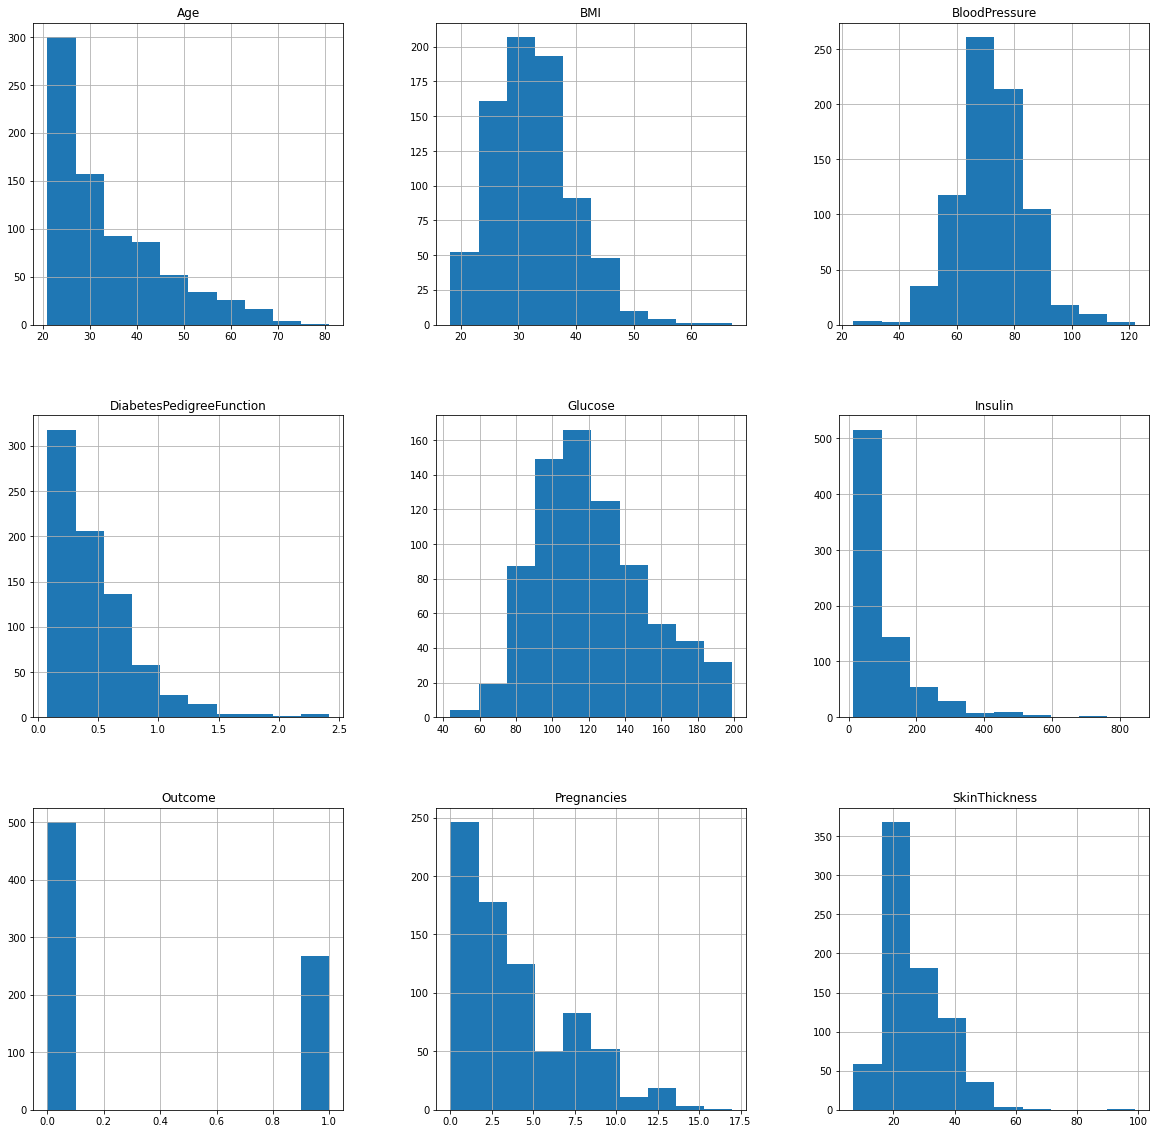

In [21]:
new_hist = data1.hist(figsize = (20,20))

### Skewness Info

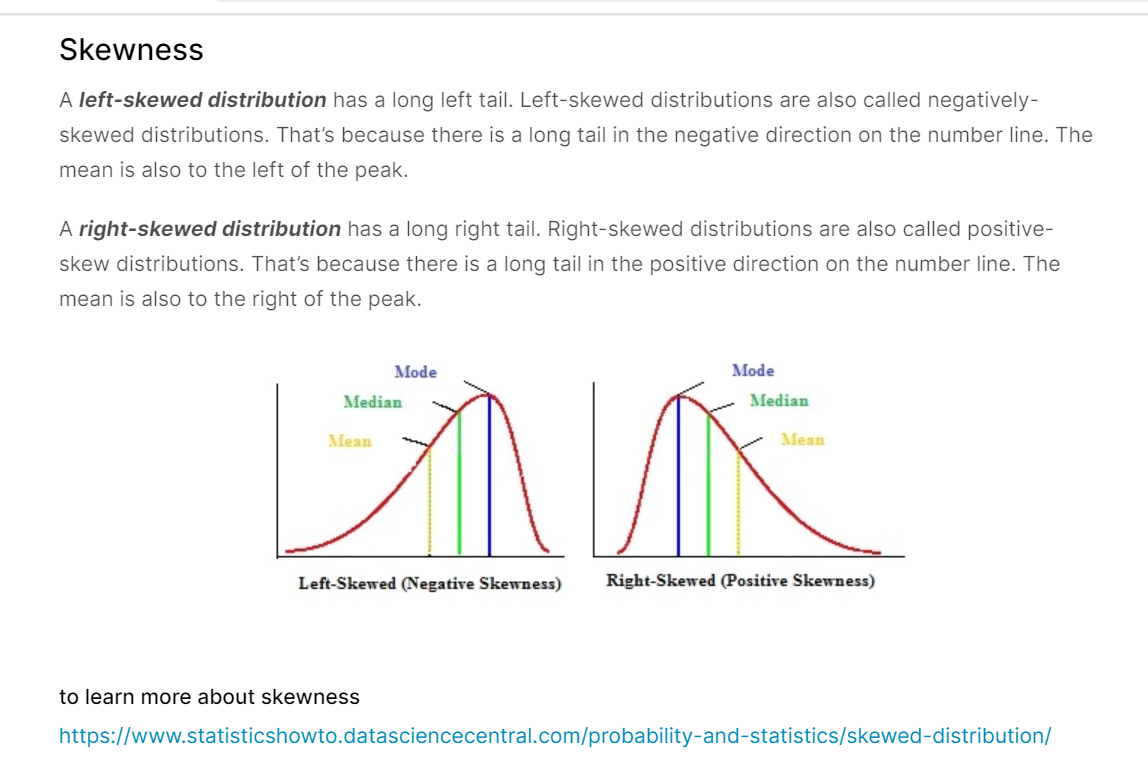

In [22]:
sns.countplot(data = data1, y = data1.dtypes)
plt.xlabel("Count of each Data Types")
plt.ylabel("Data Types")
plt.show()

TypeError: data type "Pregnancies" not understood

In [23]:
data1.dtypes

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [24]:
# Fixing the issue
# data1['Pregnancies'] = data1['Pregnancies'].astype(str) # Doesnt't  work


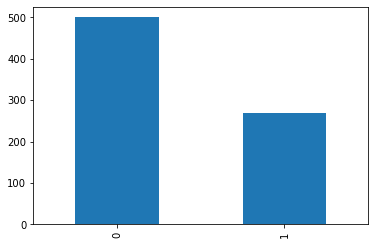

In [25]:
# Plot bargraph of Outcome column

data1.Outcome.value_counts().plot(kind = 'bar')

### Scatter Matrix of Uncleaned Data

Using pandas's scatter_matrix function
scatter matrix


In [30]:
from pandas.plotting import scatter_matrix


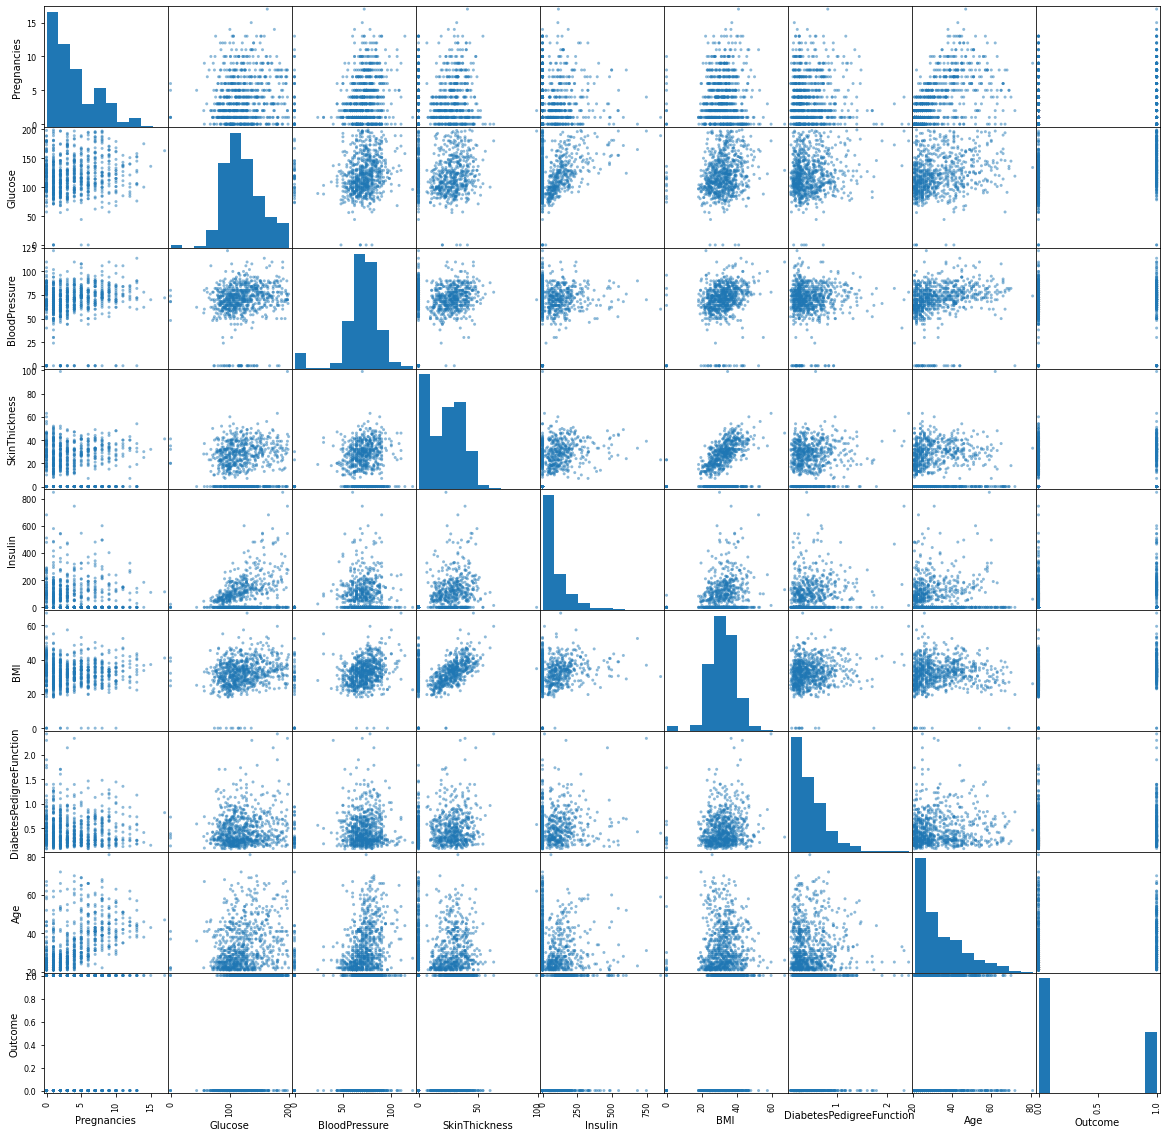

In [33]:
p = scatter_matrix(data, figsize=(20,20))

### Scatter Matrix of Cleaned Data



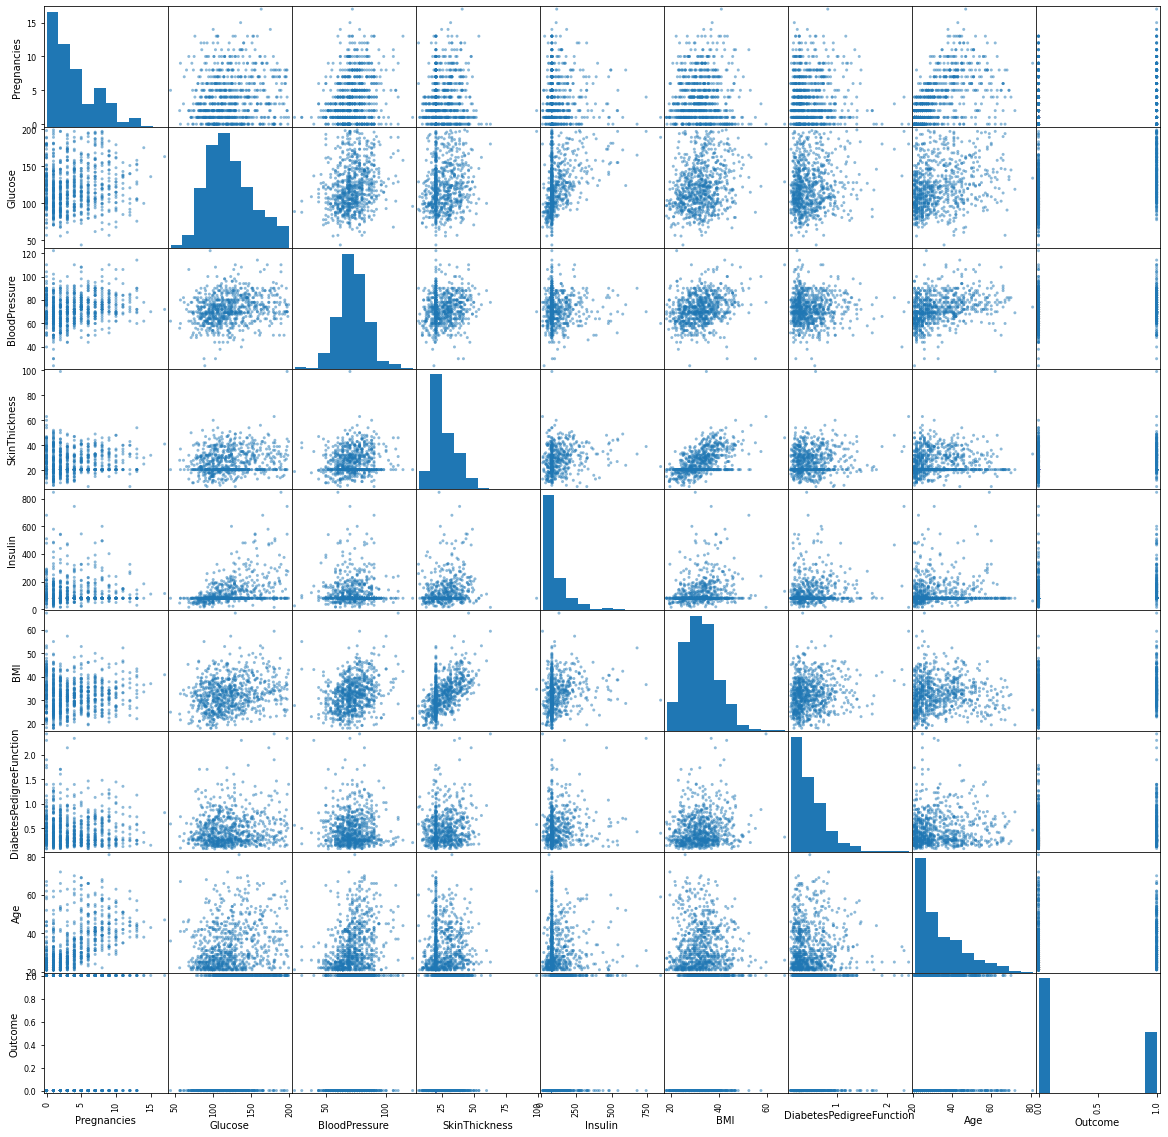

In [34]:
p1 = scatter_matrix(data1, figsize = (20,20))

Scatter Matrix allows us to visualize the histogram and scatter plots at the same time. The histogram shows the distribution of the data while the scatter plot shows the relationship between 2 variables (positive, negative or no relationship)

### Pairplots for Clean Data

Read more [here](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

Pairplots pair the relationships between two variables in a dataset. 

By default, this function will create a grid of Axes such that each numeric variable in data will by shared in the y-axis across a single row and in the x-axis across a single column. The diagonal Axes are treated differently, drawing a plot to show the univariate distribution of the data for the variable in that column.

**Parameters**

hue: string (variable name)

Variable in dataset to map plot aspects to different colors

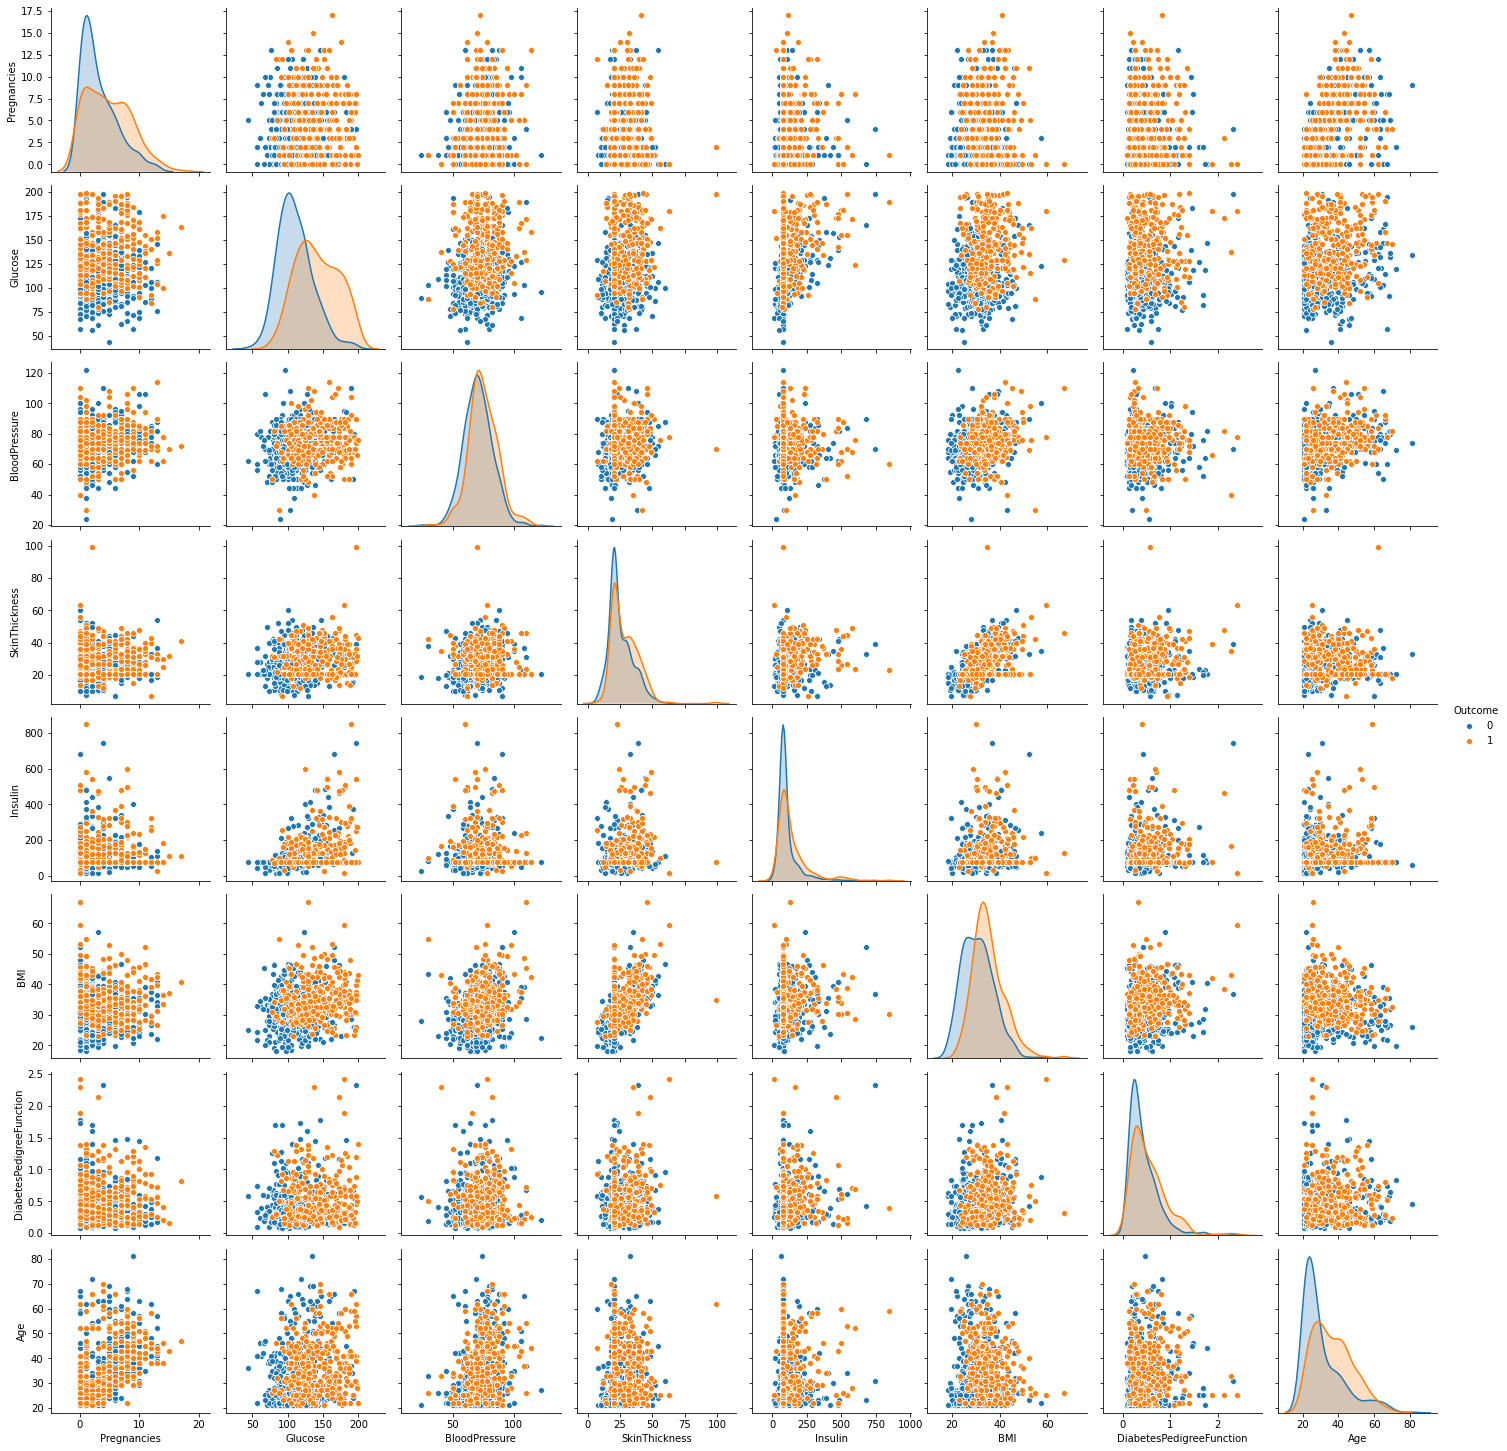

In [37]:
# Pairplots for Clean Data
# In this case we are interested to match the different predictor variables to "Outcome"

p2 = sns.pairplot(data1, hue = "Outcome")

### Heatmap Correlation

Read more [here](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

In [38]:
data1.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.127964,0.208984,0.013376,-0.018082,0.021546,-0.033523,0.544341,0.221898
Glucose,0.127964,1.000000,0.219666,0.160766,0.396597,0.231478,0.137106,0.266600,0.492908
BloodPressure,0.208984,0.219666,1.000000,0.134155,0.010926,0.281231,0.000371,0.326740,0.162986
SkinThickness,0.013376,0.160766,0.134155,1.000000,0.240361,0.535703,0.154961,0.026423,0.175026
Insulin,-0.018082,0.396597,0.010926,0.240361,1.000000,0.189856,0.157806,0.038652,0.179185
BMI,0.021546,0.231478,0.281231,0.535703,0.189856,1.000000,0.153508,0.025748,0.312254
DiabetesPedigreeFunction,-0.033523,0.137106,0.000371,0.154961,0.157806,0.153508,1.000000,0.033561,0.173844
Age,0.544341,0.266600,0.326740,0.026423,0.038652,0.025748,0.033561,1.000000,0.238356
Outcome,0.221898,0.492908,0.162986,0.175026,0.179185,0.312254,0.173844,0.238356,1.000000


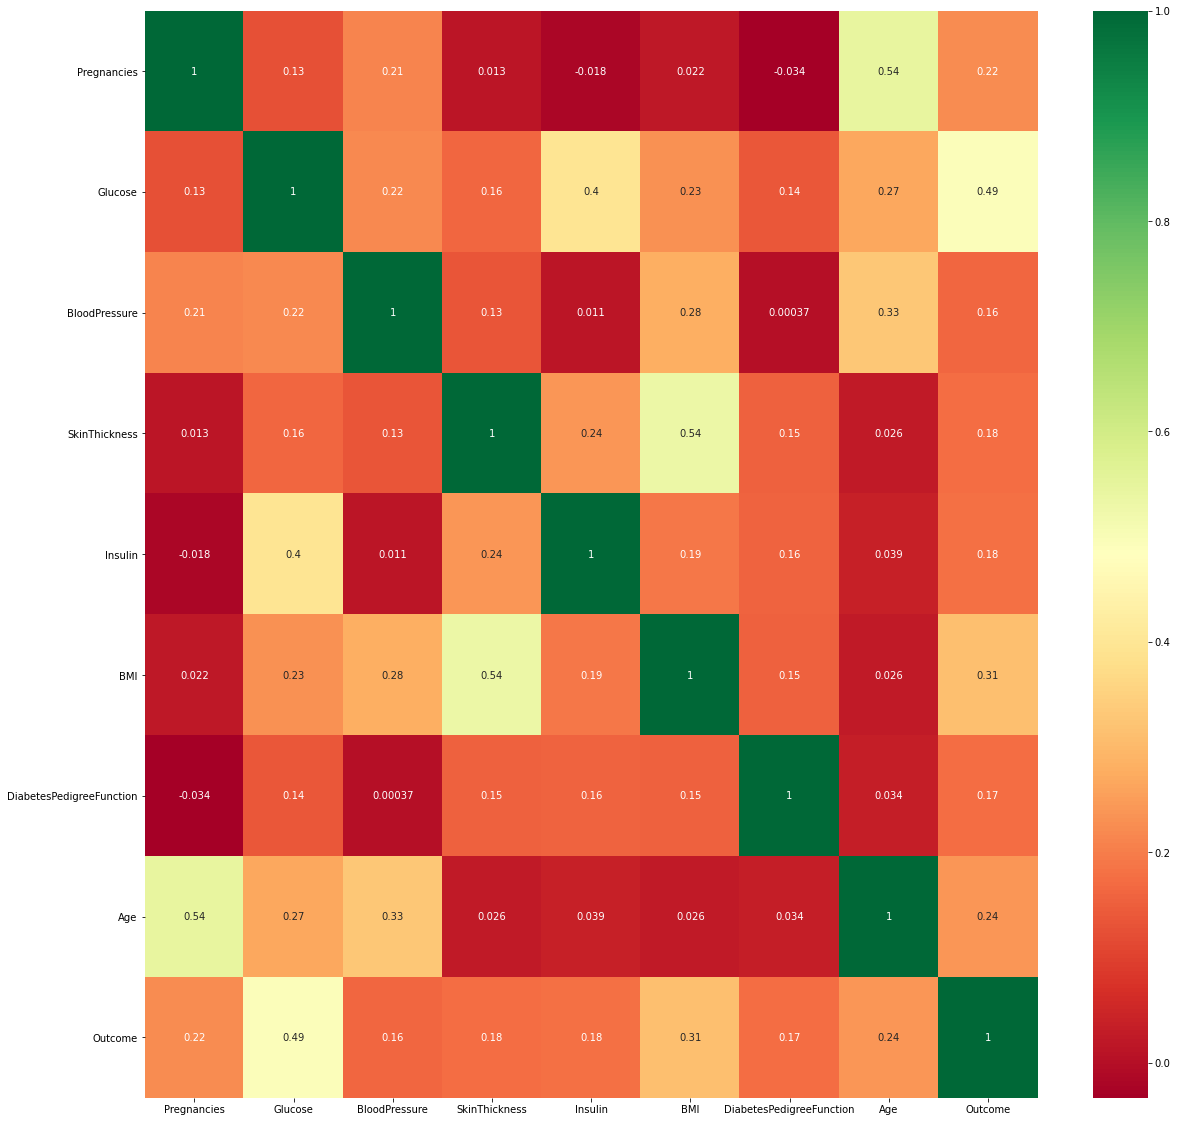

In [44]:
f, ax = plt.subplots(figsize = (20,20))

#cmap : matplotlib colormap
#annot: True, write the data value in each cell. 
p = sns.heatmap(data = data1.corr(), cmap = 'RdYlGn', annot = True)

# Analyse Date/ML

**Data Rescaling Methods**

1) Normalizing the Data

Normalization refers to rescaling real valued numeric attributes into the range 0 and 1.

It is useful to scale the input attributes for a model that relies on the magnitude of values, such as distance measures used in k-nearest neighbors and in the preparation of coefficients in regression.

Read more [here](https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/)



2) Standardization

Standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance).

It is useful to standardize attributes for a model that relies on the distribution of attributes such as Gaussian processes.


In [52]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# Temporary drop the data1['Outcome'] column

# data2 = data1.drop(['Outcome'], axis = 1)
# data2

# sc.fit_transform (data, columns = )
## Create a new dataframe after that 

# scaled_data = pd.DataFrame(sc.fit_transform(data2), columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
#        'BMI', 'DiabetesPedigreeFunction', 'Age'])
# scaled_data.head()

scaled_data = sc.fit_transform(data2)
scaled_data


array([[ 0.63994726,  0.86527574, -0.0210444 , ...,  0.16725546,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20598931, -0.51658286, ..., -0.85153454,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01597855, -0.68176235, ..., -1.33182125,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02240928, -0.0210444 , ..., -0.90975111,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14197684, -1.01212132, ..., -0.34213954,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94297153, -0.18622389, ..., -0.29847711,
        -0.47378505, -0.87137393]])

In [54]:
# Make it into a dataframe with the column names

scaled_data = pd.DataFrame(scaled_data, columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])
scaled_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865276,-0.021044,0.872057,-0.417768,0.167255,0.468492,1.425995
1,-0.844885,-1.205989,-0.516583,0.248678,-0.417768,-0.851535,-0.365061,-0.190672
2,1.233880,2.015979,-0.681762,-0.630654,-0.417768,-1.331821,0.604397,-0.105584
3,-0.844885,-1.074480,-0.516583,-0.374700,-0.265107,-0.633222,-0.920763,-1.041549
4,-1.141852,0.503626,-2.663916,0.872057,0.530423,1.549899,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.679954,0.309315,2.222711,0.659428,0.065376,-0.908682,2.532136
764,-0.547919,0.010468,-0.186224,0.040885,-0.417768,0.632988,-0.398282,-0.531023
765,0.342981,-0.022409,-0.021044,-0.374700,-0.071599,-0.909751,-0.685193,-0.275760
766,-0.844885,0.141977,-1.012121,-0.630654,-0.417768,-0.342140,-0.371101,1.170732


Create our X and Y variables for the modelling

X = All the predictor variables = scaled_data


Y = Outcome column = data1.Outcome

In [57]:
y = data1.Outcome


In [60]:
x = scaled_data


### Train Test Split

Read more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [62]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42, stratify = y)


### KNeighborsClassfier

You can determine the number of neighbors you want

> sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, ...)

Read more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [69]:
# Use 20 Neighbors

from sklearn.neighbors import KNeighborsClassifier

# Create empty lists for us to append the respective x_train, y_train scores
# and respective x_test, y_test scores

train_score = []
test_score = []

for i in range (1, 15):
    neigh = KNeighborsClassifier(i)
    neigh.fit(x_train, y_train) # X should be caps next time
    
    train_score.append(neigh.score(x_train, y_train))
    test_score.append(neigh.score(x_test, y_test))
    
    

**Determine the max train score and max test score and the respective K value**

In [75]:
max_train_score = max(train_score)
train_scores_ind = [i for i, v in enumerate(train_score) if v == max_train_score]
print(f'Max train score/accuracy {max_train_score * 100}% and k = {list(map(lambda x: x+1, train_scores_ind))}')



Max train score/accuracy 100.0 % and k = [1]


In [77]:
max_test_score = max(test_score)
test_scores_ind = [i for i, v in enumerate(test_score) if v == max_test_score]
print(f'Max test score/accuracy {max_test_score * 100}% and k = {list(map(lambda x: x+1, test_scores_ind))}')



Max test score/accuracy 74.80314960629921% and k = [11]


### Comparing with Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression().fit(x_train, y_train)
prediction = model.predict(x_test)
prediction = model.score(x_train, y_train)

print (f'Max test score/accuracy {prediction*100}%')

Max test score/accuracy 78.79377431906615%


### Result Visualisation

Since the max accuracy is achieved when k=11, hence 11 is used for the final model

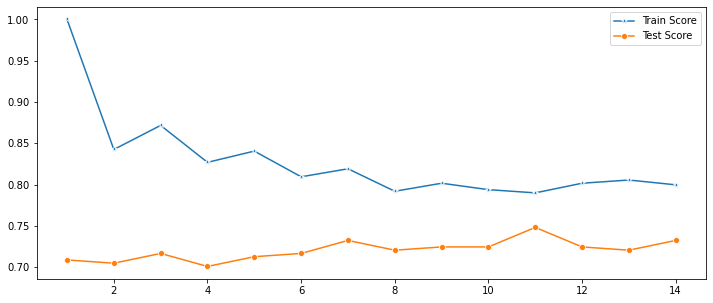

In [92]:
plt.figure(figsize = (12, 5))
p = sns.lineplot(range (1,15), train_score, marker = '*', label = 'Train Score')
p2 = sns.lineplot(range(1,15), test_score, marker = 'o', label = 'Test Score')
plt.show()

In [139]:

# based on the orange graph, highest max score is when K=11
neigh = KNeighborsClassifier(11)
neigh.fit(x_train, y_train)
pred = neigh.score(x_test, y_test)
print (f'Max test score/accuracy {pred*100}%')


Max test score/accuracy 74.80314960629921%


### Plot Decision Regions in 2D

Read more [here](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/)\

Example 7: Decision regions with more than two training features must define the filler values

> # Plotting decision regions

> plot_decision_regions(X, y, clf=svm, legend=2)

> Adding axes annotations

> plt.xlabel('sepal length [cm]')

> plt.ylabel('petal length [cm]')

> plt.title('SVM on Iris')

> plt.show()

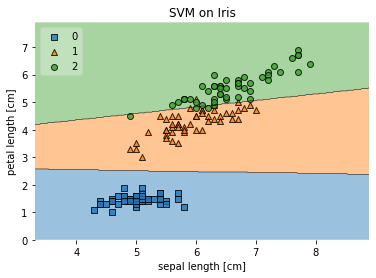

c:\users\night\appdata\local\programs\python\python38\lib\site-packages\mlxtend\plotting\decision_regions.py:244: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,
c:\users\night\appdata\local\programs\python\python38\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


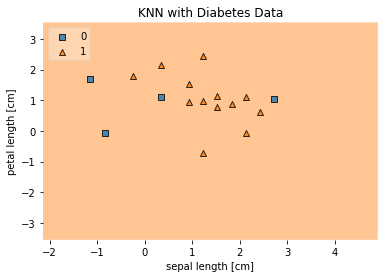

In [109]:
# Plotting decision regions
## Chose your model. Our case is knn. It can be SVM (must be define as a variable above)

# Import
from mlxtend.plotting import plot_decision_regions
knn = neigh
value = 2000
width = 2000

## filler_values must be defined for decision regions with more than two training features

plot_decision_regions(x.values, y.values, clf=knn, legend=2, 
                     
                      filler_feature_values={2: value, 3: value, 4: value, 5: value, 6: value, 7: value},
                      filler_feature_ranges={2: width, 3: width, 4: width, 5: width, 6: width, 7: width},
                     
                     )

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('KNN with Diabetes Data')
plt.show()

# Interpret Data

Methods

1) Confusion Matrix

2) ROC Curve Score

Read more [here](https://www.youtube.com/watch?v=OAl6eAyP-yo)

ROC is normally use visualize perfomrance of a binary classifier (either 0 or 1)

### Confusion Matrix

In [110]:
from sklearn.metrics import confusion_matrix

#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(x_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,140,25,165
1,39,50,89
All,179,75,254


Text(0.5, 15.0, 'Predicted label')

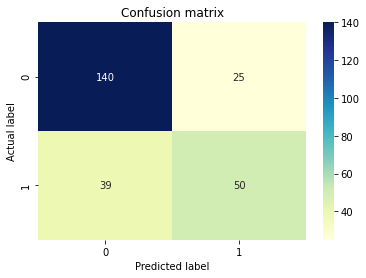

In [140]:
_pred = knn.predict(x_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

## annot=True will show the cell values

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

140 True Positive 25 False Negative

39 False Positive 50 True Negative

### ROC - AUC 

Read more [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

In [132]:
from sklearn.metrics import roc_curve

## predict_proba(self, X) returns the probability estimates for the test data X

y_pred_proba = knn.predict_proba(x_test) # scores
print (y_pred_proba.shape)
y_pred_proba = y_pred_proba[:, 1]
print (y_pred_proba.shape)

# fpr: false positive rates
# tpr: true positive rates

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) # roc_curve(y, scores)


(254, 2)
(254,)


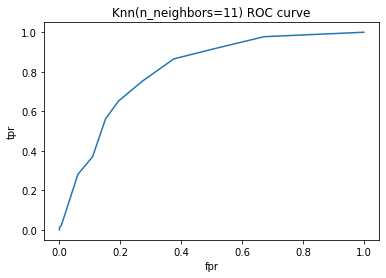

In [133]:
# Plot ROC graph

plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

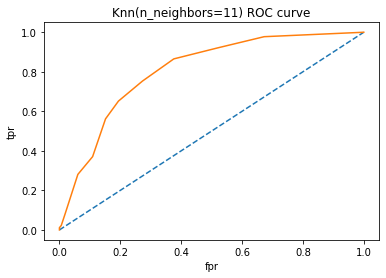

In [137]:
# Add straight line
plt.plot([0,1], [0,1], "--")
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

In [138]:
# Compute area under ROC curve

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba)

0.8057201225740551

The area under the ROC curve gives an idea about the benefit of using the test in question. It is the measure of the usefulness of a test where a greater area means a more useful test.

Some random article [here](https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-used)



Based on the result of the KNN decision region and the ROC curve, using KNN classifier is a good test as the area is relatively high

Using the KNN classification we have a 74% accuracy of using the normalized predictor variables to predict if someone has Diabetes or not. It will return a binary outcome of either 0 or 1


### Hyper Parameter Optimization

See code example and explanation [here](https://www.kaggle.com/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed)